<a href="https://colab.research.google.com/github/Vaishnavi23278/Customer-Churn-Prediction-Model/blob/main/Customer_churn_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Step 2: Load your dataset (upload it to Colab or mount Google Drive)
df = pd.read_csv("/WA_Fn-UseC_-Telco-Customer-Churn.csv")  # Replace with your actual file
df.head()



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Step 3: Preprocess the data just like in Flask app

def preprocess_input(df):
    df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
    df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
    df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
    df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
    df['MultipleLines'] = df['MultipleLines'].map({ 'Yes': 1, 'No': 0, 'No phone service': 0 })
    df['InternetService'] = df['InternetService'].map({ 'DSL': 0, 'Fiber optic': 1, 'No': 2 })
    df['OnlineSecurity'] = df['OnlineSecurity'].map({ 'Yes': 1, 'No': 0, 'No internet service': 0 })
    df['OnlineBackup'] = df['OnlineBackup'].map({ 'Yes': 1, 'No': 0, 'No internet service': 0 })
    df['DeviceProtection'] = df['DeviceProtection'].map({ 'Yes': 1, 'No': 0, 'No internet service': 0 })
    df['TechSupport'] = df['TechSupport'].map({ 'Yes': 1, 'No': 0, 'No internet service': 0 })
    df['StreamingTV'] = df['StreamingTV'].map({ 'Yes': 1, 'No': 0, 'No internet service': 0 })
    df['StreamingMovies'] = df['StreamingMovies'].map({ 'Yes': 1, 'No': 0, 'No internet service': 0 })
    df['Contract'] = df['Contract'].map({ 'Month-to-month': 0, 'One year': 1, 'Two year': 2 })
    df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
    df['PaymentMethod'] = df['PaymentMethod'].map({
        'Electronic check': 0, 'Mailed check': 1,
        'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3 })

    df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)
    df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce').fillna(0)
    df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce').fillna(0)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

    return df


In [ ]:
# Step 4: Apply preprocessing and prepare features
df_processed = preprocess_input(df.copy())

# Drop ID column if present
if 'customerID' in df_processed.columns:
    df_processed.drop('customerID', axis=1, inplace=True)

# Separate target
y = df_processed['Churn'].map({'Yes': 1, 'No': 0})
X = df_processed.drop('Churn', axis=1)

# Save feature names for later use
training_columns = list(X.columns)


In [ ]:
# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
# Step 6: Train base model
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X_train, y_train)

# Step 7: Calibrate probabilities
calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
calibrated_model.fit(X_train, y_train)


CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42))

ROC AUC Score: 0.8331253713606654


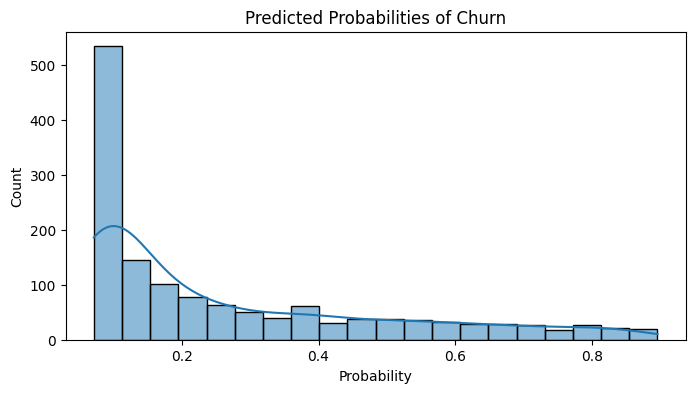

In [ ]:
# Step 8: Predict and evaluate
y_proba = calibrated_model.predict_proba(X_test)[:, 1]

# Evaluate with ROC AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plot histogram of probabilities
plt.figure(figsize=(8, 4))
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Predicted Probabilities of Churn")
plt.xlabel("Probability")
plt.show()


In [ ]:

from sklearn.metrics import precision_recall_curve

# Get probabilities for positive class (Churn = 1)
y_probs = calibrated_model.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

# F1-score calculation
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_index = f1_scores.argmax()  # Get the index of the best F1 score
selected_threshold = thresholds[best_index]

print("Best Threshold:", selected_threshold)
print("Best F1 Score:", f1_scores[best_index])


Best Threshold: 0.44225953127095136
Best F1 Score: 0.9126208598247196


In [ ]:
import joblib
import pickle

# Save the final model (calibrated model)
joblib.dump(calibrated_model, 'calibrated_model.pkl')

# Save the selected threshold
with open('selected_threshold.pkl', 'wb') as f:
    pickle.dump(selected_threshold, f)

# Save the training columns (assuming you have them stored)
with open('training_columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)


In [ ]:

from google.colab import files

# Download the saved models
files.download('calibrated_model.pkl')
files.download('selected_threshold.pkl')
files.download('training_columns.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>